In [47]:
import warnings
import numpy as np
from scipy.stats import (norm, lognorm, 
                         beta, triang, 
                         gamma, percentileofscore)
import matplotlib.pyplot as plt
from math import log, exp
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns

# Section

## Subsection

lorem ipsum

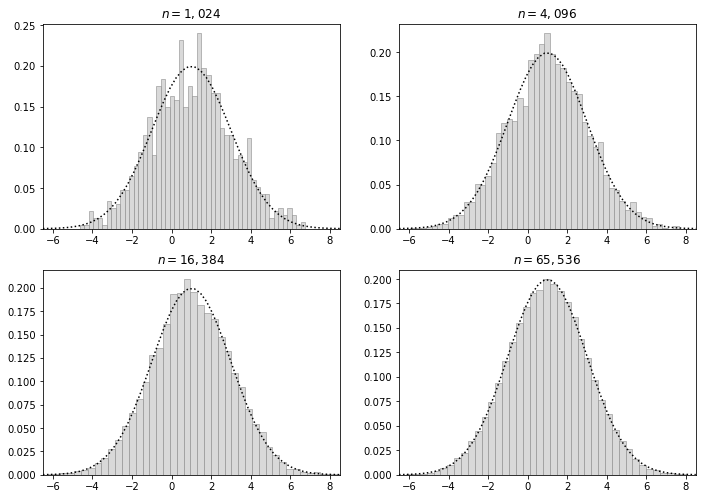

In [48]:
d = norm(loc=1, scale=2)
fig, ax = plt.subplots(2, 2, figsize=(11.7, 8.3))
ax = ax.flatten()
x = np.linspace(-6.5, 8.5)
y = d.pdf(x)
for i, n in enumerate(np.logspace(5, 8, num=4, base=4)):
    ax[i].hist(d.rvs(int(n)), bins=50, density=True,
               fc='0.85', ec='0.5', lw=0.5,)
    ax[i].set_title("$n={:,.0f}$".format(n))
    ax[i].plot(x, y, c='k', ls=':')
    ax[i].set_xlim(-6.5, 8.5)
plt.show()

In [49]:
def define_norm(P10, P90, **kwargs):
    mean = (P90+P10)/2 
    std = (P10-P90)/(norm.ppf(0.9)-norm.ppf(0.1))
    return norm(loc=mean, scale=std)
    

def define_lognorm(P10, P90, **kwargs):
    std = log(P10 / P90) / (norm.ppf(0.9) - norm.ppf(0.1))
    mean = (log(P10) - 2**0.5 * std 
            * (gamma.ppf(0.8, a=0.5, scale=1))**0.5)
    return lognorm(s=std, scale=exp(mean))


def define_triang(mini, mode, maxi):
    c = (mode - mini)/(maxi - mini)
    scale = maxi - mini
    return triang(c=c, loc=mini, scale=scale)


def define_beta(P10, P90, mini, maxi):
    loc = mini
    scale = maxi - loc
    f = lambda x, a, b: beta.ppf(x, a, b, loc, scale)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        a, b = curve_fit(f, [0.1, 0.9], [P90, P10])[0]
    return beta(a=a, b=b, loc=loc, scale=scale)

In [50]:
params = {
    'GRV':      define_lognorm(P90=10_000_000, P10=25_000_000),
    'NTG':      define_norm(P90=0.4, P10=0.6),
    'Porosity': define_beta(P90=0.125, P10=0.225, mini=0.05, maxi=0.3),
    'Sw':       define_triang(mini=0.1, maxi=0.6, mode=0.25),
    'FVF':      define_norm(P90=1.1, P10=1.3),
    'RF':       define_norm(P90=0.15, P10=0.25),
}
realisations = pd.DataFrame([], columns=params)

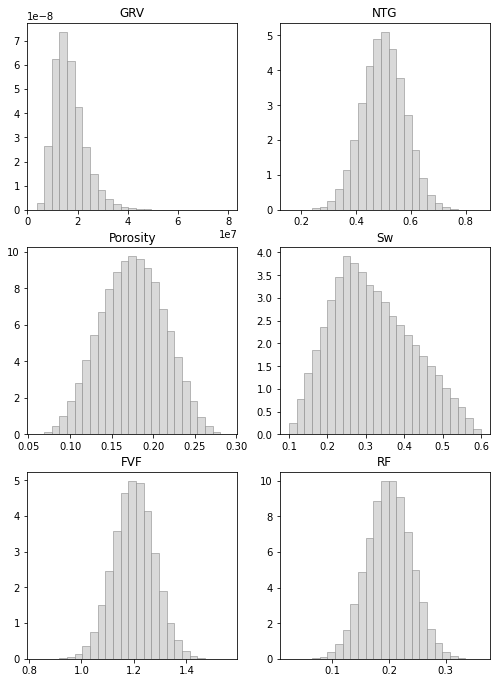

In [51]:
num_samples = 100_000

fig, ax = plt.subplots(nrows=(len(params) // 2 
                              + len(params) % 2),
                       ncols=2,
                       figsize=(8.3, 11.7))
ax = ax.flatten()

for i, (k, v) in enumerate(params.items()):
    x = v.rvs(num_samples)
    realisations[k] = x
    ax[i].hist(x, bins=25, density=True,
               fc='0.85', ec='0.5', lw=0.5,)
    ax[i].set_title(k)
plt.show()

In [52]:
realisations['STOOIP'] = (realisations['GRV']
                     * realisations['NTG']
                     * realisations['Porosity']
                     * (1 - realisations['Sw'])
                     / realisations['FVF']
                     / 1_000 / 159)
realisations['Resource'] = realisations['STOOIP'] * realisations['RF']

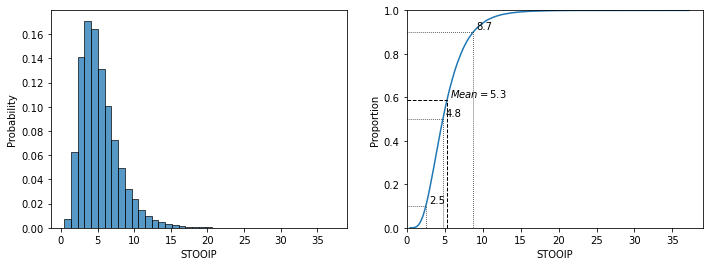

In [53]:
fig, ax = plt.subplots(ncols=2, figsize=(11.7,4))
sns.histplot(realisations.STOOIP, ax=ax[0], stat='probability', bins=40)
sns.ecdfplot(realisations.STOOIP, ax=ax[1])
ax[1].set_xlim(left=0)
for p in [0.1, 0.5, 0.9]:
    q = realisations.STOOIP.quantile(p)
    ax[1].plot([0] + [q] * 2,
               [p] * 2 + [0],
               c='k', ls=":", lw=0.75)
    ax[1].annotate('{:.1f}'.format(q), 
                   (q, p),
                   xytext=(3, 3),
                   textcoords='offset pixels')
mean = realisations.STOOIP.mean()
Pmean = percentileofscore(
    realisations.STOOIP,
    mean,
    kind='weak')/100
ax[1].plot([0] + [mean] * 2,
               [Pmean] * 2 + [0],
               c='k', ls="--", lw=1)
ax[1].annotate('$Mean={:.1f}$'.format(mean), 
               (mean, Pmean),
               xytext=(3, 3),
               textcoords='offset pixels')
plt.show()

In [67]:
realisations.describe()

,GRV,NTG,Porosity,Sw,FVF,RF,STOOIP,Resource
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.685561e+07,0.500425,0.175024,0.317110,1.199768,0.200052,5.309834,1.062389
std,6.242087e+06,0.077904,0.037771,0.104584,0.077812,0.039006,2.674238,0.583625
min,3.673703e+06,0.155587,0.059660,0.100331,0.828836,0.024094,0.433070,0.065048
25%,1.240171e+07,0.447727,0.148072,0.237513,1.147387,0.173901,3.414700,0.651490
50%,1.580758e+07,0.500248,0.175306,0.304773,1.199945,0.200087,4.765140,0.937061
75%,2.011196e+07,0.552942,0.202170,0.391389,1.252413,0.226373,6.596724,1.330845
max,7.991534e+07,0.854473,0.289670,0.598786,1.557779,0.361459,37.239147,7.044077


In [68]:
realisations.describe(percentiles=[0.1, 0.5, 0.9],)

,GRV,NTG,Porosity,Sw,FVF,RF,STOOIP,Resource
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.685561e+07,0.500425,0.175024,0.317110,1.199768,0.200052,5.309834,1.062389
std,6.242087e+06,0.077904,0.037771,0.104584,0.077812,0.039006,2.674238,0.583625
min,3.673703e+06,0.155587,0.059660,0.100331,0.828836,0.024094,0.433070,0.065048
10%,9.999957e+06,0.400877,0.124911,0.187105,1.099714,0.149901,2.517359,0.467091
50%,1.580758e+07,0.500248,0.175306,0.304773,1.199945,0.200087,4.765140,0.937061
90%,2.497405e+07,0.600175,0.224678,0.467889,1.299284,0.249994,8.748572,1.808830
max,7.991534e+07,0.854473,0.289670,0.598786,1.557779,0.361459,37.239147,7.044077


In [80]:
def formatter(s):
    formats = {
        'Sw':       '{:.1%}',
        'Porosity': '{:.1%}',
        'FVF':      '{:.2}',
        'RF':       '{:.1%}',
        'GRV':      '{:,.1g}',
        'STOOIP':   '{:,.1f}',
        'Resource':  '{:,.1f}',
        'NTG':      '{:.1%}',
    }
    return(s.apply(formats[s.name].format))

def borders(s):
    fmt = 'border-top: 1px solid black; ' \
          + 'font-weight: bold'
    return [fmt for e in s]

summary = realisations.describe(percentiles=[0.1, 0.5, 0.9],) \
    .apply(formatter).T \
    .iloc[:,[3,4,5,6,7,1]]
summary.columns = ['Min', 'P90', 'P50', 'P10', 'Max', 'Mean']
summary.style.apply(borders, axis=1, 
                    subset=pd.IndexSlice[['STOOIP', 'Resource'], :]).render()

'<style  type="text/css" >\n#T_d4157_row6_col0,#T_d4157_row6_col1,#T_d4157_row6_col2,#T_d4157_row6_col3,#T_d4157_row6_col4,#T_d4157_row6_col5,#T_d4157_row7_col0,#T_d4157_row7_col1,#T_d4157_row7_col2,#T_d4157_row7_col3,#T_d4157_row7_col4,#T_d4157_row7_col5{\n            border-top:  1px solid black;\n             font-weight:  bold;\n        }</style><table id="T_d4157_" ><thead>    <tr>        <th class="blank level0" ></th>        <th class="col_heading level0 col0" >Min</th>        <th class="col_heading level0 col1" >P90</th>        <th class="col_heading level0 col2" >P50</th>        <th class="col_heading level0 col3" >P10</th>        <th class="col_heading level0 col4" >Max</th>        <th class="col_heading level0 col5" >Mean</th>    </tr></thead><tbody>\n                <tr>\n                        <th id="T_d4157_level0_row0" class="row_heading level0 row0" >GRV</th>\n                        <td id="T_d4157_row0_col0" class="data row0 col0" >4e+06</td>\n                      

,Min,P90,P50,P10,Max,Mean
GRV,4e+06,1e+07,2e+07,2e+07,8e+07,2e+07
NTG,15.6%,40.1%,50.0%,60.0%,85.4%,50.0%
Porosity,6.0%,12.5%,17.5%,22.5%,29.0%,17.5%
Sw,10.0%,18.7%,30.5%,46.8%,59.9%,31.7%
FVF,0.83,1.1,1.2,1.3,1.6,1.2
RF,2.4%,15.0%,20.0%,25.0%,36.1%,20.0%
STOOIP,0.4,2.5,4.8,8.7,37.2,5.3
Resource,0.1,0.5,0.9,1.8,7.0,1.1


In [90]:
from IPython.display import Javascript
import urllib.parse

Javascript("const code = Jupyter.notebook.get_cell(1).get_text(); IPython.notebook.kernel.execute(`myvar = '${encodeURI(code)}'`);")
urllib.parse.unquote(myvar)

'# Section\n\n## Subsection\n\nlorem ipsum'

In [88]:
myvar

'#%20Section%0A%0A##%20Subsection%0A%0Alorem%20ipsum'

In [92]:
import markdown

In [93]:
html = markdown.markdown(myvar)

In [94]:
html

'<h1>%20Section%0A%0A##%20Subsection%0A%0Alorem%20ipsum</h1>'

In [96]:
md = markdown.Markdown(extensions=['latex'])

ModuleNotFoundError: No module named 'latex'